In [1]:
import bs4; print( 'bs4 ' + bs4.__version__)
from bs4 import BeautifulSoup, SoupStrainer

import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk; print( 'nltk ' + nltk.__version__)
from nltk import word_tokenize, pos_tag, RegexpParser;
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, LancasterStemmer

# from autocorrect import spell; print('autocorrect 0.3.0')

import re; print('re ' + re.__version__)
import requests; print('requests ' + requests.__version__)

import pandas as pd; print('pandas ' + pd.__version__)
import seaborn as sns; print('seaborn ' + sns.__version__)

import pyLDAvis; print('pyLDAvis ', pyLDAvis.__version__)
import pyLDAvis.sklearn

import matplotlib; print('matplotlib', matplotlib.__version__)
import matplotlib.pyplot as plt;

bs4 4.6.3
sklearn 0.19.1
nltk 3.3
re 2.2.1
requests 2.19.1
pandas 0.22.0
seaborn 0.8.1
pyLDAvis  2.1.2
matplotlib 2.2.2


# Final Project - Topic Modeling

First we continue where we left off with [Homework 5](https://github.com/kjprice/smu-nlp/blob/e769b93945e6f45ae90aab3ec53b6595ae7bc7da/homework/Homework%205.ipynb).

### Code from Homework 5


In [2]:
# The home page for various movies' reviews, from which will get the links for individual reviews
review_home_urls = {
    'green_mile': 'https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3',
    'forest_gump': 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt',
    'cast_away': 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt',
    'terminal': 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3',
    'catch_me_if_you_can': 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3',
    'road_to_perdition': 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3',
}
def get_text_from_url(url):
    return requests.get(url).text
text = get_text_from_url(review_home_urls['green_mile'])


In [3]:
def get_all_links_from_html(html):
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a', href=True))
    urls = [str(tag.attrs['href']) for tag in tags]
    return urls
all_links = get_all_links_from_html(text)

In [4]:
def get_review_urls_from_links(links):
    url_template = 'https://www.imdb.com{}'
    # url_template = 'http://www.gutenberg.org/files/{}/{}-h/{}-h.htm'
    return [url_template.format(link) for link in links]

urls = get_review_urls_from_links(all_links)

In [5]:
def relevent_link(link):
    if '/review/' in link:
        return True
    return False

In [6]:
def get_relevent_links(links):
    relevent_links = filter(relevent_link, all_links)
    unique_relevent_links = set(relevent_links)
    return list(unique_relevent_links)
relevent_urls = get_relevent_links(urls)
len(relevent_urls)

25

In [7]:
def strain_content(name, attrs):
    if name == 'div' and dict(attrs).get('class', None) == 'content':
        return True
    return False
def clean_review_text(text):
    return re.split('\\n\\n\s+\d+ out of \d+', text)[0]
def get_review_from_url(url):
    html = get_text_from_url(url)
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer(strain_content))
    review = clean_review_text(tags.text)
    return review

<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-fe7ee7139024>:6: DeprecationWarning: invalid escape sequence \s
  return re.split('\\n\\n\s+\d+ out of \d+', text)[0]


In [8]:
def get_review_from_site(url):
    reviews = []

    reviews_home_text = get_text_from_url(url)
    all_links = get_all_links_from_html(reviews_home_text)
    relevent_links = get_relevent_links(all_links)

    
    
    
    review_urls = get_review_urls_from_links(relevent_links)
    for url in review_urls:
        reviews.append(get_review_from_url(url))
        # break
    return reviews

In [9]:
def get_reviews_from_all_sites():
    all_reviews = []
    review_titles = review_home_urls.keys()
    for title in review_titles:
        review_home_url = review_home_urls[title]
        all_reviews = all_reviews + get_review_from_site(review_home_url)
    return all_reviews

## Retrieve All Reviews

In [10]:
all_reviews = get_reviews_from_all_sites()

In [11]:
len(all_reviews)

150

In [12]:
all_reviews[0][0:100]

'\nHaving doubts about seeing this movie because of the length (3 hours can be death to a film).I was '

## Preprocess Data

In [13]:
def sentences_to_words(sentences):
    return [word_tokenize(sentence) for sentence in sentences]
# sentences_to_words([all_reviews[0]])[0][0:5]

In [14]:
custom_stop_words = ['the', 'green', 'mile', 'shawshank', 'redemption', 'one']
stop_words = custom_stop_words + stopwords.words('english')
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]
remove_stop_words(['he', 'her', 'boss', '.', 'the'])

['boss', '.']

In [15]:
def include_only_numbers_and_letters(words):
    regex_matcher = '^[a-zA-Z0-9]+$'
    return [word for word in words if re.match(regex_matcher, word)]
# include_only_numbers_and_letters(['1', 'KJ', '.'])

In [16]:
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')
stemmer = LancasterStemmer()
def lemmatize_word(word):
    lemma_word = stemmer.stem(word)
    if wordnet.synsets(lemma_word):
        return lemma_word
    else:
        return word
def lemmatize_words(words):
    return [lemmatize_word(word) for word in words]
lemmatize_words(['running', 'fastest', 'hats', 'movie'])

['run', 'fastest', 'hat', 'movie']

In [17]:
def preprocess_documents(documents):
    documents_with_formatted_words = [document.lower().strip() for document in documents]
    documents_of_words = sentences_to_words(documents_with_formatted_words)
    content_words_and_characters = [remove_stop_words(words) for words in documents_of_words]
    content_words = [include_only_numbers_and_letters(characters) for characters in content_words_and_characters]
    lematized_words = [lemmatize_words(words) for words in content_words]
    return lematized_words  
preprocess_documents(all_reviews[0:2])[0][0:5]

['doubt', 'see', 'movie', 'length', '3']

In [18]:
documents_of_words = preprocess_documents(all_reviews)
documents_of_words[0][0:7]

['doubt', 'see', 'movie', 'length', '3', 'hour', 'dea']

### Take a look at words

In [19]:
list_of_all_words = [word for document in documents_of_words for word in document]
len(list_of_all_words)

17454

In [20]:
# Unique Words
len(set(list_of_all_words))

1134

### Flatten documents back to sentences

In [21]:
flattened_documents = [' '.join(document) for document in documents_of_words]

## Perform Topic Modeling

Inspired, in part by https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [22]:
# Settings
NUMBER_OF_FEATURES = 1000
NUMBER_OF_TOPICS  = 10
NUMBER_OF_TOP_WORDS = 10

In [23]:
def topics_to_map(model, feature_names, no_top_words):
    map = []
    for topic_idx, topic in enumerate(model.components_):
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        map.append(stuff)
    return map


In [24]:
# Helper function 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx))
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print (stuff)

### Vectorize (Bag Of Words)

In [25]:
tf_vectorizer = TfidfVectorizer(max_features=NUMBER_OF_FEATURES)
tf = tf_vectorizer.fit_transform(flattened_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [26]:
flattened_documents[0][0:100]

'doubt see movie length 3 hour dea film surprised look watch throughout whole movie tom hank opinion '

### NMF

In [27]:
nmf = NMF(n_components=NUMBER_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf)

In [28]:
nmf_topic_map = topics_to_map(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)
display_topics(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0:
prison film paul guard coffey john story man duncan mak
Topic 1:
gave movie long whole hop perform side pussycat depth known
Topic 2:
movie watch movies ev ca seen feel poss think recommend
Topic 3:
book read great story would screen movie king job several
Topic 4:
products art never us cent provide profit unfortunately expense pond
Topic 5:
scenes film talented keep quiver ensemble edge screenwriter provides conclusion
Topic 6:
rich ful either pick chock stamina squeamish creepy dat de
Topic 7:
world love year hop watch outlook disgust 12 pure destruct
Topic 8:
find right edgecomb member period injustice shad toward study compel
Topic 9:
twice wo dvd excess saw trail pretty disappoint buy october


### LDA

In [29]:
lda = LatentDirichletAllocation(n_topics=NUMBER_OF_TOPICS, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)



/usr/local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [30]:
display_topics(lda, tf_feature_names, NUMBER_OF_TOP_WORDS)


Topic 0:
prison men heart steven stay darabont king movie man emotional
Topic 1:
see cast excel october buy wo trail saw pretty dvd
Topic 2:
movie book perform hop gave long film michael read david
Topic 3:
movie watch ev seen think movies love tear story tissues
Topic 4:
products art film never scenes us ostensible sorry provide react
Topic 5:
mak edgecomb paul find hum duncan michael hank right pain
Topic 6:
movie forget poss recommend emotions would movies experience ca anyone
Topic 7:
book story three yet movie several cast screen hour five
Topic 8:
mom steal pick lay award watchingboth us enough mad penal
Topic 9:
rich ful either stamina squeamish rank reason desert required creepy


In [31]:
topic_map = nmf.transform(tf)

# Visualizations

With help from https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [32]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [33]:
tsne_lda = tsne_model.fit_transform(topic_map)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.067913
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.277386
[t-SNE] Error after 1000 iterations: -3.305540


In [34]:
categories = review_home_urls.keys()

In [35]:
categories_vector = []
for category in categories:
    for i in range(int(len(all_reviews) / len(categories))):
        categories_vector.append(category)

In [36]:
x = pd.DataFrame({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    'group': categories_vector,
    text: all_reviews
})

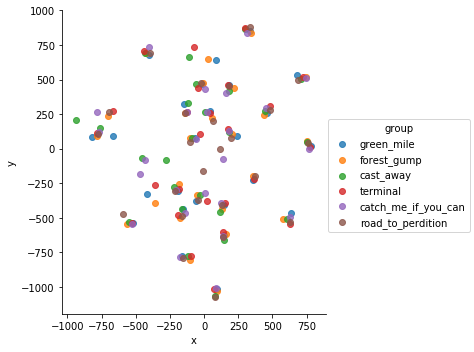

In [37]:
sns.lmplot(x='x', y='y', fit_reg=False, data=x, hue='group', x_jitter=40, y_jitter=40)

### pyLDAvis

In [38]:
# Help by https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(nmf, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      42.295401        1       1   27.327932  164.008331
2      19.234170        1       2 -412.613525   57.829952
1       9.335602        1       3  382.196533 -225.432907
3       7.460797        1       4 -218.842285  326.878784
4       4.310667        1       5   35.242233 -378.301697
6       3.748459        1       6 -291.335327 -303.214813
8       3.731814        1       7  130.442856  -95.509811
7       3.482339        1       8 -146.076859  -54.533775
5       3.212483        1       9  353.872040  133.033325
9       3.188267        1      10  149.001205  420.516846, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
106   Default   6.000000       book   6.000000  30.0000  30.0000
532   Default  20.000000      movie  20.000000  29.0000  29.0000
359   Default  10.000000       film  10.000000  28.0000  28.0000
637   Default   6.000000     prison   6.000000  27.0000  27.0000
375   Default   4.000000       gave   4.000000  26.0000  26.0000
998   Default   4.000000       year   4.000000  25.0000  25.0000
323   Default   8.000000         ev   8.000000  24.0000  24.0000
960   Default   7.000000      watch   7.000000  23.0000  23.0000
412   Default   5.000000        hum   5.000000  22.0000  22.0000
407   Default   5.000000        hop   5.000000  21.0000  21.0000
294   Default   4.000000   edgecomb   4.000000  20.0000  20.0000
361   Default   3.000000       find   3.000000  19.0000  19.0000
831   Default   7.000000      story   7.000000  18.0000  18.0000
602   Default   6.000000    perform   6.000000  17.0000  17.0000
999   Default   3.000000        yet   3.000000  16.0000  16.0000
491   Default   3.000000       love   3.000000  15.0000  15.0000
41    Default   3.000000    another   3.000000  14.0000  14.0000
973   Default   4.000000      whole   4.000000  13.0000  13.0000
483   Default   6.000000       long   6.000000  12.0000  12.0000
741   Default   5.000000        see   5.000000  11.0000  11.0000
744   Default   6.000000       seen   6.000000  10.0000  10.0000
731   Default   3.000000     scenes   3.000000   9.0000   9.0000
499   Default   6.000000        mak   6.000000   8.0000   8.0000
988   Default   2.000000      world   2.000000   7.0000   7.0000
523   Default   6.000000    michael   6.000000   6.0000   6.0000
884   Default   3.000000      three   3.000000   5.0000   5.0000
669   Default   2.000000       read   2.000000   4.0000   4.0000
542   Default   3.000000      never   3.000000   3.0000   3.0000
218   Default   2.000000        cry   2.000000   2.0000   2.0000
712   Default   3.000000      right   3.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
982   Topic10   1.179323         wo   1.179323   3.4457  -3.5261
634   Topic10   1.179323     pretty   1.179323   3.4457  -3.5261
915   Topic10   1.179323      twice   1.179323   3.4457  -3.5261
903   Topic10   1.179323      trail   1.179323   3.4457  -3.5261
728   Topic10   1.179323        saw   1.179323   3.4457  -3.5261
287   Topic10   1.179323        dvd   1.179323   3.4457  -3.5261
124   Topic10   1.179323        buy   1.179323   3.4457  -3.5261
882   Topic10   0.989894    thought   1.230852   3.2278  -3.7012
318   Topic10   0.989894     enough   1.230852   3.2278  -3.7012
462   Topic10   0.989894       lead   1.230852   3.2278  -3.7012
991   Topic10   0.989894      worth   1.322872   3.1557  -3.7012
796   Topic10   0.989894       soon   1.413778   3.0893  -3.7012
524   Topic10   0.873768      might   1.428655   2.9540  -3.8259
610   Topic10   0.989894    picture   1.637175   2.9426  -3.7012
356   Topic10   0.873768        far   1.516470   2.8944  -3.8259
477   Topic10   0.989894      liked   1.762554   2.8688  -3.7012
816   Topic10   0.873768      stand   1.716034   2.7707  -3.8259
65    Topic

### Heatmap

In [42]:
words = tf_vectorizer.get_feature_names()

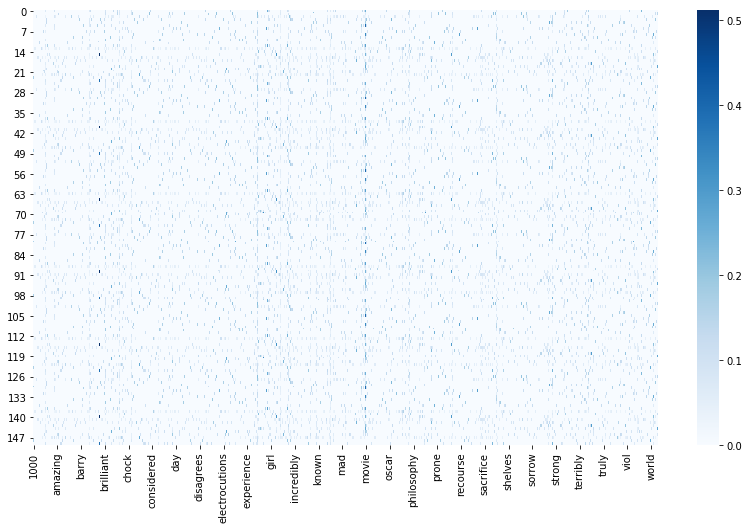

In [43]:
sns.heatmap(pd.DataFrame(tf.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8)

### Frequency of categories and topics

### Testing stuff

In [44]:
import numpy as np

In [45]:
primary_topics = [np.argmax(transformed_topics) for transformed_topics in lda.transform(tf)]

In [46]:
primary_topics_text = [nmf_topic_map[topic_index] for topic_index in primary_topics]

In [47]:
a = tf[0]

In [48]:
tf_vectorizer.inverse_transform(a)

[array(['doubt', 'see', 'movie', 'length', 'hour', 'dea', 'film',
        'surprised', 'look', 'watch', 'throughout', 'whole', 'tom', 'hank',
        'opinion', 'gave', 'perform', 'car', 'bring', 'emotion', 'depth',
        'part', 'act', 'bet', 'michael', 'clark', 'duncan', 'mad', 'giant',
        'like', 'character', 'vulnerable', 'pussycat', 'marvel', 'cast',
        'cam', 'together', 'best', 'seen', 'long', 'time', 'let', 'side',
        'weak', 'david', 'mors', 'known', 'support', 'roles', 'also',
        'excel', 'hop', 'till', 'carry', 'get', 'forget', 'run', 'connect',
        'enjoy', 'little', 'miracle'], dtype='<U14')]